### «Прогнозування та дослідження операцій. Частина «Оптимізація»

In [359]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import numpy as np

1.	(Лінійне програмування) 

написати модель планування ресурсів на наступний рік, використовуючи додаткову інформацію:

•	На 2 тони врожаю потрібно залучити 1 працівника

•	Працівників можна наймати, використовуючи 4 типи контрактів:

- 3 місячний термін, страховий збір 300 у.о. на початку, мзп 1000 у.о.  
- 4 місячний термін, щомісячний страховий збір 110 у.о., мзп 900 у.о 
- 7 місячний термін, щомісячний страховий збір 110 у.о. перші 3 місяці і 90 у.о. наступні 4 місяці, бонус по завершенні контракту 100 у.о, мзп 950 у.о.
- 5 місячний термін, початковий бонус 450 у.о., мзп 950 у.о

Цю задачу можна перетворити в наступну:

Є проміжок, поділений на 12 частин і кожна з частин має бути покритим мінімальною кількістю блоків

Розглядатимемо також умову, за якою люди працюватимуть без звільнень, тобто вони точно завершуватимуть свій період роботи.

Ці періоди у даній задачі будуть репрезентуватись як блоки певної довжини зі своєю загальною вартістю (тією, у яку компанії обходиться один працівник у кінцевому результаті)


Типи блоків, які відповідатимуть умові:

In [360]:
type_1 = (3, [300, 1000, 1000, 1000])
type_2 = (4, [0, 900+110, 900+110, 900+110, 900+110])
type_3 = (7, [0, 110+950, 110+950, 110+950, 90+950, 90+950, 90+950, 90+950+100])
type_4 = (5, [450, 950, 950, 950, 950, 950])

Створюємо загальну вартість блоку для кожного типу

In [361]:
def calculate_general_salary(salary_plan):
    n = len(salary_plan)
    new_list = [salary_plan[0]]
    for i in range(1, n):
        new_list.append(salary_plan[i]+ new_list[i-1])
    return new_list

In [362]:
salary_1 = calculate_general_salary(type_1[1])

Якщо б можна було звільняти працівників до завершення домовленого періоду за контрактом, до уваги брались би дані, розподілені за місяцями:

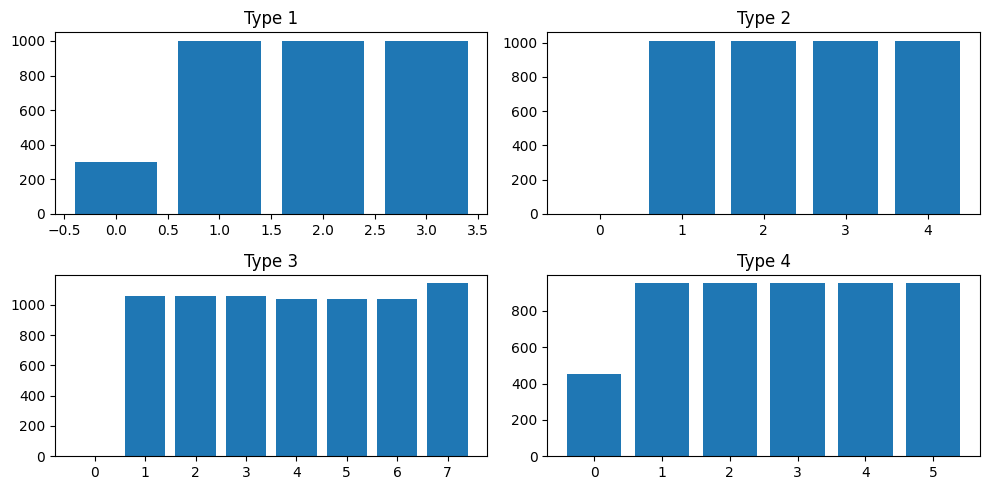

In [363]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.bar(range(type_1[0]+1), type_1[1])
plt.title('Type 1')

plt.subplot(2, 2, 2)
plt.bar(range(type_2[0]+1), type_2[1])
plt.title('Type 2')

plt.subplot(2, 2, 3)
plt.bar(range(type_3[0]+1), type_3[1])
plt.title('Type 3')

plt.subplot(2, 2, 4)
plt.bar(range(type_4[0]+1), type_4[1])
plt.title('Type 4')


plt.tight_layout()
plt.show()


Але в даному випадку використовуватимуться нескорочувані блоки своєї довжини(періоду), тому опції для вибору залишатимуться такими:

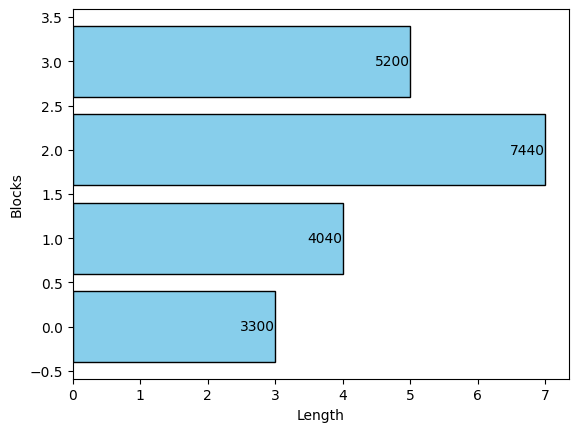

In [364]:
blocks = [[3, 3300], 
            [4, 4040], 
            [7, 7440], 
            [5, 5200]]

block_lengths = [block[0] for block in blocks]
prices = [block[1] for block in blocks]
fig, ax = plt.subplots()

bars = ax.barh(range(len(blocks)), block_lengths, color='skyblue', edgecolor='black')


for bar, text in zip(bars, prices):
    x_val = bar.get_width()
    y_val = bar.get_y() + bar.get_height() / 2
    ax.text(x_val, y_val, str(text), va='center', ha='right')

ax.set_xlabel('Length')
ax.set_ylabel('Blocks')

plt.show()

У задачі зазначено, що для виробництва 2-ох тон зерна потрібно залучити 1-го працівника, відповідно для обрахунку мінімальної кількості людей для кожного місяця(мінімальної кількості блоків на один проміжок) обраховуватиметься за формулою:

monthly_production / 2

Тоді, маючи план продукції, можемо отримати щомісячну кількість працівників:



In [365]:
target_production = [367.147, 350.773, 320.989, 
                     315.163, 295.472, 274.848, 
                     303.273, 299.824, 327.777, 
                     325.285, 378.159, 392.429] 


needed_people_per_month = [int(x/2)+1 for x in target_production] 
needed_blocks_per_month = np.array(needed_people_per_month)
needed_blocks_per_month


array([184, 176, 161, 158, 148, 138, 152, 150, 164, 163, 190, 197])

Після переформулювання поставленої задачі і генерування усіх потрібних вхідних даних, переходимо до імплементації пошуку мінімальної вартості, використаної на блоки, щоб задовільнити умову покриття кожного відрізку певною кількістю блоків:

In [366]:
constraint_matrix = np.zeros((12, 12*4), dtype=np.int64)
for i, l in enumerate(block_lengths):
    for b in range(12):
        start = b-l+1
        if start < 0:
            start = 0
        end = b+1
        if end > 12:
            end = 12
        for j in range(start, end):
            constraint_matrix[b, j+i*12] = 1     
constraint_matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       

In [367]:
constraint_matrix = pd.DataFrame(constraint_matrix)
bounds = [(0, None) for _ in range(12*4)]
coeffs = np.array([i for i in prices for _ in range(12)])
needed = -np.array(np.ceil(np.array(target_production)/2))

In [368]:
coeffs

array([3300, 3300, 3300, 3300, 3300, 3300, 3300, 3300, 3300, 3300, 3300,
       3300, 4040, 4040, 4040, 4040, 4040, 4040, 4040, 4040, 4040, 4040,
       4040, 4040, 7440, 7440, 7440, 7440, 7440, 7440, 7440, 7440, 7440,
       7440, 7440, 7440, 5200, 5200, 5200, 5200, 5200, 5200, 5200, 5200,
       5200, 5200, 5200, 5200])

In [369]:
bounds

[(0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None)]

In [370]:
needed

array([-184., -176., -161., -158., -148., -138., -152., -150., -164.,
       -163., -190., -197.])

In [371]:
constraint_matrix.index+=1
constraint_matrix.columns+=1
constraint_matrix


,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
5,0,0,1,1,1,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
6,0,0,0,1,1,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,0,0,0,...,1,1,1,1,1,0,0,0,0,0
8,0,0,0,0,0,1,1,1,0,0,...,0,1,1,1,1,1,0,0,0,0
9,0,0,0,0,0,0,1,1,1,0,...,0,0,1,1,1,1,1,0,0,0
10,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,1,1,1,1,0,0


In [372]:
result = scipy.optimize.linprog(coeffs, -constraint_matrix.iloc[:12, :], needed)
result

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 2099060.0
              x: [ 2.800e+01  0.000e+00 ...  0.000e+00  0.000e+00]
            nit: 9
          lower:  residual: [ 2.800e+01  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [ 0.000e+00  2.560e+03 ...  1.900e+03
                              1.900e+03]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  8.000e+00  2.300e+01  0.000e+00
                              0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00  7.000e+00  0.000e+00]
                 marginals: [-3.300e+03 -0.000e+00 -0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


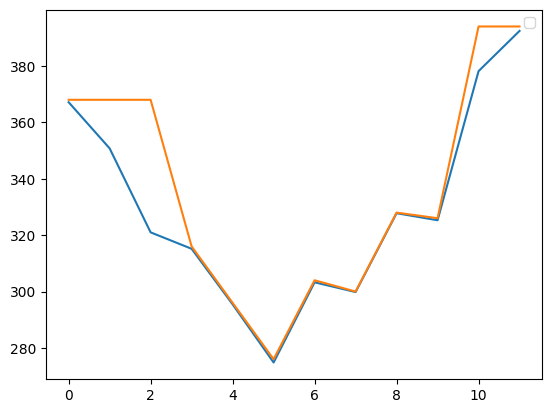

In [373]:
optimal = np.asmatrix(np.ceil(result.x))
resulting = np.asmatrix(constraint_matrix.iloc[:12, :]) * np.asmatrix(optimal).transpose()
plt.plot(target_production)
plt.plot(resulting*2)
plt.legend()
plt.show()

кількість людей, що працюватимуть щомісяця обночасно 

In [374]:
resulting

matrix([[184.],
        [184.],
        [184.],
        [158.],
        [148.],
        [138.],
        [152.],
        [150.],
        [164.],
        [163.],
        [197.],
        [197.]])

план, за яким відбуватиметься найм працівників

In [375]:
planning = optimal.reshape(4, -1).transpose()
planning # of hiring

matrix([[ 28., 146.,   0.,  10.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   2.,   0.,   0.],
        [  0., 136.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [ 14.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0., 150.,   0.,   0.],
        [ 13.,   0.,   0.,   0.],
        [ 34.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]])

Кінцевий обрахунок результуючих витрат

In [376]:
number_of_blocks = np.sum(planning, axis=0) #[ 89. 434.   0.  10.]
number_of_blocks = [89, 434, 0, 10]
prices = [3300, 4040, 7440, 5200]
general = 0
for i in range(4):
    general += prices[i]*number_of_blocks[i]
general

2099060

2.	(Лінійне програмування) Користуючись ноутбуком supply_chain_task.ipynb згенеруйте вхідні дані для задачі. Вхідними даними будуть:


a.	Кластери (фактично міста), де люди будуть купляти товар з відповідною оцінкою потрібної кількості  (на практиці це результати моделей прогнозування);

b.	Множина складів, які можуть приймати та відправляти товари;

c.	Множина портів, які можуть приймати кораблі;

d.	Місткість вантажівок та контейнерів;

e.	Ціни на перевезення вантажівкою та доставки додому.

Потрібно скласти оптимальний ланцюг поставок, щоб зекономити загальні витрати та покрити очікуваний попит.



In [377]:
import numpy as np
import pandas as pd
import geopy.distance as distance
from faker import Faker
fake = Faker()
student_id_last_3 = 369
all_ports_df = pd.read_csv("ports.txt", delimiter="\t")

Генерування вхідних даниз для задачі:

In [378]:
np.random.seed(369)
number_of_warehouses = np.random.randint(8, 15)
number_of_clusters = np.random.randint(35, 60)
number_of_ports = np.random.randint(8, 12)
port_indices = np.random.choice(np.arange(all_ports_df.shape[0]), size=number_of_ports, replace=False)
demand = np.random.randint(50, 150, number_of_clusters) 
container_capacity = np.random.randint(20, 26)

In [379]:
Faker.seed(student_id_last_3)
warehouses = []
while True:
    rand_place = fake.local_latlng(country_code="US")
    if not warehouses:
        warehouses.append(rand_place)
    else:
        min_dist = min([distance.geodesic(p[:2], rand_place[:2]).km for p in warehouses])
        if min_dist > 550:
            warehouses.append(rand_place)
    if len(warehouses) == number_of_warehouses:
        break
    
clusters = []
while True:
    rand_place = fake.local_latlng(country_code="US")
    if not clusters:
        clusters.append(rand_place)
    else:
        min_dist = min([distance.geodesic(p[:2], rand_place[:2]).km for p in clusters])
        if min_dist > 100:
            clusters.append(rand_place)
    if len(clusters) == number_of_clusters:
        break

ports_df = all_ports_df.loc[port_indices]

In [380]:
ports_df

,Place Name,Latitude,Longitude
5,"Port Tampa Bay Cruise Ship Terminal, Tampa, FL...",27.945423,-82.444099
15,"Navy Pier Terminal, Chicago, IL, USA",41.892654,-87.610168
0,"South Street Seaport, New York City, NY, USA",40.706322,-74.002640
4,"Port Miami Cruise Terminal, Miami, FL, USA",25.778803,-80.177994
9,"Port Everglades Cruise Ship Terminal, Fort Lau...",26.085421,-80.117775
11,"Raymond L. Flynn Black Falcon Cruise Terminal,...",42.343651,-71.033020
1,"Seattle Smith Cove Cruise Terminal 91, Seattle...",47.633301,-122.379654
12,"Port Jersey, Bayonne, NJ, USA",40.664871,-74.072571
7,"Long Beach Cruise Terminal, Long Beach, CA, USA",33.751305,-118.188812
16,"Port of Boston, MA, USA",42.364506,-71.038887


In [381]:
warehouses_df = pd.DataFrame(warehouses)
warehouses_df[5] = warehouses_df.apply(lambda x: " ".join([x[3], x[2], x[4]]), axis=1)

clusters_df = pd.DataFrame(clusters)
clusters_df[5] = clusters_df.apply(lambda x: " ".join([x[3], x[2], x[4]]), axis=1)


In [382]:
warehouses_df

,0,1,2,3,4,5
0,40.65538,-74.38987,Scotch Plains,US,America/New_York,US Scotch Plains America/New_York
1,28.15112,-82.46148,Lutz,US,America/New_York,US Lutz America/New_York
2,32.35126,-95.30106,Tyler,US,America/Chicago,US Tyler America/Chicago
3,34.09611,-118.10583,San Gabriel,US,America/Los_Angeles,US San Gabriel America/Los_Angeles
4,47.38093,-122.23484,Kent,US,America/Los_Angeles,US Kent America/Los_Angeles
5,39.43534,-84.20299,Lebanon,US,America/New_York,US Lebanon America/New_York
6,31.84568,-102.36764,Odessa,US,America/Chicago,US Odessa America/Chicago
7,33.54428,-84.23381,Stockbridge,US,America/New_York,US Stockbridge America/New_York
8,47.92526,-97.03285,Grand Forks,US,America/Chicago,US Grand Forks America/Chicago
9,29.84576,-90.10674,Estelle,US,America/Chicago,US Estelle America/Chicago


In [383]:
clusters_df

,0,1,2,3,4,5
0,40.58654,-122.39168,Redding,US,America/Los_Angeles,US Redding America/Los_Angeles
1,32.52515,-93.75018,Shreveport,US,America/Chicago,US Shreveport America/Chicago
2,32.54044,-82.90375,Dublin,US,America/New_York,US Dublin America/New_York
3,37.60876,-77.37331,Mechanicsville,US,America/New_York,US Mechanicsville America/New_York
4,25.67927,-80.31727,Kendall,US,America/New_York,US Kendall America/New_York
5,42.24113,-88.3162,Crystal Lake,US,America/Chicago,US Crystal Lake America/Chicago
6,40.5576,-74.28459,Woodbridge,US,America/New_York,US Woodbridge America/New_York
7,41.27621,-72.86843,East Haven,US,America/New_York,US East Haven America/New_York
8,32.9156,-117.14392,Mira Mesa,US,America/Los_Angeles,US Mira Mesa America/Los_Angeles
9,38.70734,-77.02303,Fort Washington,US,America/New_York,US Fort Washington America/New_York


In [384]:
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
 
fig = go.Figure(
            data=go.Scattergeo(
                lon = warehouses_df[1],
                lat = warehouses_df[0],
                text = warehouses_df[5],
                mode = 'markers',
                marker = dict(
                              size=20,
                              symbol="square",
                              color="green"
                              )
                ))
fig.add_trace(go.Scattergeo(
                lon = clusters_df[1],
                lat = clusters_df[0],
                text = clusters_df[5],
                mode = 'markers',
                marker = dict(
                              size=15,
                              symbol="circle",
                              color="blue"
                              )
                ))

fig.add_trace(go.Scattergeo(
                lon = ports_df["Longitude"],           
                lat = ports_df["Latitude"],
                text = ports_df["Place Name"],
                mode = 'markers',
                marker = dict(
                              size=25,
                              symbol="triangle-up",
                              color="red"
                              )
                ))


fig = fig.update_layout(showlegend=False,
                        geo=go.layout.Geo(scope="usa", showland=True),
                        width=1080, height=680)
fig.show()

У даній задачі потрібно врахувати наступні умови:

- спочатку доставка відбувається з портів до місць збереження за вартістю на пальне, розраховане для першого типу транспорту(скоріш за все, це великі вантажівки для далекого перевезення)

- подальше постачання можуть виконувати ті ж вантажівки або інший вид транспорту, але вартість на пальне на 1км зросте, так як у насиченішому трафіку споживання збільшується

- враховуючи обмеження простору у місцях збереження продукції та у кластерах (скоріш за все, магазинах - кінцевих місць постачання), потрібно доставити ту кількість, яка зазначена у списку demand



Алгоритм для одного проміжного місця збереження виглядатиме наступним чином:

- якщо спільний demand у прив'язаних кластерів менший, за вільне місце - завезти цю кількість і передавати далі на доставку в магазини 

- якщо більший, завозити максимальну дозволену кількість та передавати до кластерів до того моменту, поки міста не буде забезпечено продукцією відповідно до попиту


У даній задачі можливі різні моделі:

- кожна вантажівка розподілена або лише на міжміські перевезення, або лише на відправлення від місць збереження до магазинів  ->  тоді потрібно виконати 2 підзадачі: знайти накращі шляхи для міжміських і міських перевезень + знайти найкращий відсотковий розподіл транспорту для обох типів доставки

- нема обмеження для транспорту, кудою їздити(що звучить менш реалістично для застосування у житті через існуючі правила користування великим транспортом серед міста у зв'язку з викидами газів), але тоді задача може мати суттєво інші шляхи

Перетворення даних для подальшого використання:

In [385]:
# warehouses_df.insert(6, 6, container_capacity)
warehouses_df.columns = ["lat", "lng", "w_name", "us", "state", "full_address"]
warehouses_df.drop(columns=['w_name', 'us', 'state'], inplace=True)

clusters_df.insert(6, "demand", demand)
clusters_df.columns = ["lat", "lng", "c_name", "us", "state", "full_address", "demand"]
clusters_df.drop(columns=['c_name', 'us', 'state'],     inplace=True)

In [386]:
warehouses_df.head()

,lat,lng,full_address
0,40.65538,-74.38987,US Scotch Plains America/New_York
1,28.15112,-82.46148,US Lutz America/New_York
2,32.35126,-95.30106,US Tyler America/Chicago
3,34.09611,-118.10583,US San Gabriel America/Los_Angeles
4,47.38093,-122.23484,US Kent America/Los_Angeles


In [387]:
clusters_df.head()

,lat,lng,full_address,demand
0,40.58654,-122.39168,US Redding America/Los_Angeles,107
1,32.52515,-93.75018,US Shreveport America/Chicago,63
2,32.54044,-82.90375,US Dublin America/New_York,108
3,37.60876,-77.37331,US Mechanicsville America/New_York,132
4,25.67927,-80.31727,US Kendall America/New_York,77


In [388]:
ports_df.columns = ["full_address", "lat", "lng"]
ports_df = ports_df[["lat", "lng", "full_address"]]
ports_df.head()

,lat,lng,full_address
5,27.945423,-82.444099,"Port Tampa Bay Cruise Ship Terminal, Tampa, FL..."
15,41.892654,-87.610168,"Navy Pier Terminal, Chicago, IL, USA"
0,40.706322,-74.002640,"South Street Seaport, New York City, NY, USA"
4,25.778803,-80.177994,"Port Miami Cruise Terminal, Miami, FL, USA"
9,26.085421,-80.117775,"Port Everglades Cruise Ship Terminal, Fort Lau..."


In [389]:
import pandas as pd
wars = warehouses_df.copy()
clust = clusters_df.copy()
por = ports_df.copy()
wars['type'] = 'warehouse'
clust['type'] = 'cluster'
por['type'] = 'port'

combined_df = pd.concat([wars[['lat', 'lng', 'full_address', 'type']],
                        clust[['lat', 'lng', 'full_address', 'type']],
                        por[['lat', 'lng', 'full_address', 'type']]])


In [390]:
combined_df

,lat,lng,full_address,type
0,40.65538,-74.38987,US Scotch Plains America/New_York,warehouse
1,28.15112,-82.46148,US Lutz America/New_York,warehouse
2,32.35126,-95.30106,US Tyler America/Chicago,warehouse
3,34.09611,-118.10583,US San Gabriel America/Los_Angeles,warehouse
4,47.38093,-122.23484,US Kent America/Los_Angeles,warehouse
...,...,...,...,...
11,42.343651,-71.03302,"Raymond L. Flynn Black Falcon Cruise Terminal,...",port
1,47.633301,-122.379654,"Seattle Smith Cove Cruise Terminal 91, Seattle...",port
12,40.664871,-74.072571,"Port Jersey, Bayonne, NJ, USA",port
7,33.751305,-118.188812,"Long Beach Cruise Terminal, Long Beach, CA, USA",port


In [391]:
price_per_km_truck = np.random.uniform(1.2, 2.4)
price_per_km_las_mile = np.random.uniform(3.2, 5.4)
total_demand = demand.sum()
number_of_trucks = np.random.randint(10,50)
truck_capacity = np.random.randint(45, 55)

Для задачі такого типу потрібна також матриця відстаней

Її імплементація, використовуючи обрахунки за координатами:

In [392]:
from geopy.distance import geodesic

def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

def create_distance_matrix(warehouses, clusters, price):
    num_warehouses = len(warehouses)
    num_clusters = len(clusters)
    distance_matrix = np.zeros((num_warehouses, num_clusters))

    for i in range(num_warehouses):
        for j in range(num_clusters):
            warehouse_coords = (warehouses.iloc[i]['lat'], warehouses.iloc[i]['lng'])
            cluster_coords = (clusters.iloc[j]['lat'], clusters.iloc[j]['lng'])
            distance_matrix[i, j] = calculate_distance(warehouse_coords, cluster_coords)*price

    return distance_matrix

Матриця відстаней від місць зберігання до кластерів:

In [393]:
matrix_wares_clusters = create_distance_matrix(warehouses_df, clusters_df, price_per_km_las_mile)
matrix_wares_clusters = pd.DataFrame(matrix_wares_clusters)
matrix_wares_clusters.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,16353.922993,7942.685655,4805.993993,1734.790585,7135.699156,4795.111752,57.291581,593.260794,15793.367292,1275.522046,...,10945.867187,15681.291345,880.069329,9269.789947,4037.401125,3182.179278,32133.376577,15055.275641,9663.249605,5266.470924
1,15842.514568,4845.572481,1992.299682,4696.294329,1415.084511,6732.343488,6390.079118,6926.229579,13683.465234,5199.373881,...,7997.994510,16495.718080,5868.470690,5203.931007,6301.866238,3250.289054,30313.094224,15671.844881,6067.415551,4434.659797
2,10529.749115,600.056490,4753.033251,7074.258276,6665.318091,5135.984020,8505.634149,9072.270636,8349.314952,7331.047112,...,2729.797899,11532.653656,7618.383468,1273.096684,5399.570689,6603.438098,25054.635239,10673.181689,1194.528003,3248.944495
3,3320.361820,9256.648152,13322.579314,14974.451977,15274.020747,11199.980892,15941.877852,16406.518534,646.615397,15049.366019,...,6080.411661,6231.095398,15050.526891,8969.347719,11908.187070,14964.921774,16458.816344,5576.858982,8043.590034,11058.922509
4,3079.704967,11885.541216,15055.596875,15444.775079,17877.993198,11096.252700,15738.163270,16020.946350,6782.283192,15300.073367,...,9839.299504,51.445498,15001.106972,12386.179632,11866.427795,16070.658182,17346.037102,842.184449,11498.108127,12334.937070


Матриця відстаней від портів до місць зберігання:

In [394]:
matrix_wares_ports = create_distance_matrix(warehouses_df, ports_df, price_per_km_truck)
matrix_wares_ports = pd.DataFrame(matrix_wares_ports)
matrix_ports_wares = create_distance_matrix(warehouses_df, ports_df, price_per_km_truck)
matrix_ports_wares = pd.DataFrame(matrix_ports_wares)
matrix_ports_wares.head()

,0,1,2,3,4,5,6,7,8,9
0,2778.551844,1947.070050,58.011529,3029.424684,2969.575819,588.784198,6728.382699,46.891484,6847.642023,590.269385
1,39.917145,2784.251384,2781.979849,606.116490,569.540567,3288.353690,7087.587494,2769.724451,6028.327001,3291.081604
2,2322.978451,2198.585543,3690.195011,2864.951062,2845.081752,4203.810142,4965.703030,3677.800821,3735.038422,4204.362715
3,6032.493711,4885.586927,6864.591217,6553.724127,6540.075879,7277.223412,2698.349847,6854.814915,68.116418,7276.148748
4,7083.913175,4871.207162,6761.248174,7657.784110,7624.035676,7004.674673,52.569463,6755.814985,2708.784012,7002.141150


щоб мінімізувати загальну вартість доставок і покрити усі потреби міст, 

In [395]:
clusters_df['demand']
demand = np.array(clusters_df['demand'])
demand

array([107,  63, 108, 132,  77,  81,  77,  96, 121,  95, 101,  68, 126,
        76, 139, 124, 140, 123, 146,  87,  68, 145,  51,  75, 109, 121,
       148, 146, 124, 131, 109, 119,  75, 140,  59,  96,  77,  63,  98,
       106, 127, 120, 128,  71, 110,  59, 102, 133])

In [396]:
demand_dict = {clusters[i]: demand[i] for i in range(len(demand))}
demand_dict

{('40.58654', '-122.39168', 'Redding', 'US', 'America/Los_Angeles'): 107,
 ('32.52515', '-93.75018', 'Shreveport', 'US', 'America/Chicago'): 63,
 ('32.54044', '-82.90375', 'Dublin', 'US', 'America/New_York'): 108,
 ('37.60876', '-77.37331', 'Mechanicsville', 'US', 'America/New_York'): 132,
 ('25.67927', '-80.31727', 'Kendall', 'US', 'America/New_York'): 77,
 ('42.24113', '-88.3162', 'Crystal Lake', 'US', 'America/Chicago'): 81,
 ('40.5576', '-74.28459', 'Woodbridge', 'US', 'America/New_York'): 77,
 ('41.27621', '-72.86843', 'East Haven', 'US', 'America/New_York'): 96,
 ('32.9156', '-117.14392', 'Mira Mesa', 'US', 'America/Los_Angeles'): 121,
 ('38.70734', '-77.02303', 'Fort Washington', 'US', 'America/New_York'): 95,
 ('45.53929', '-122.38731', 'Troutdale', 'US', 'America/Los_Angeles'): 101,
 ('34.77453', '-96.67834', 'Ada', 'US', 'America/Chicago'): 68,
 ('33.92946', '-116.97725', 'Beaumont', 'US', 'America/Los_Angeles'): 126,
 ('35.25064', '-91.73625', 'Searcy', 'US', 'America/Chicag

словники цін на добирання між:
- портами-місцями збереження
- місцями збереження-кластерами

In [397]:
port_wares_dict = {(i, j): matrix_wares_ports.iloc[i, j] for i in range(matrix_wares_ports.shape[0]) for j in range(matrix_wares_ports.shape[1])}
# temp_dict = {}
# for item in port_wares_dict.items():
#     ware, port = item[0]
#     temp_dict[f'(Port{port}, Warehouse{ware})'] = item[1]

# port_wares_dict = temp_dict
port_wares_dict

{(0, 0): 2778.5518436731627,
 (0, 1): 1947.0700495776223,
 (0, 2): 58.01152922128532,
 (0, 3): 3029.424683992283,
 (0, 4): 2969.5758186495445,
 (0, 5): 588.7841978162519,
 (0, 6): 6728.382698845028,
 (0, 7): 46.891483634452804,
 (0, 8): 6847.642023117592,
 (0, 9): 590.269385482484,
 (1, 0): 39.917145073250886,
 (1, 1): 2784.2513841874124,
 (1, 2): 2781.979848836384,
 (1, 3): 606.1164897352268,
 (1, 4): 569.5405673519936,
 (1, 5): 3288.3536895383995,
 (1, 6): 7087.58749360169,
 (1, 7): 2769.724451254086,
 (1, 8): 6028.327000963302,
 (1, 9): 3291.08160417719,
 (2, 0): 2322.9784505599278,
 (2, 1): 2198.5855429936505,
 (2, 2): 3690.1950110285684,
 (2, 3): 2864.951061578872,
 (2, 4): 2845.0817518466424,
 (2, 5): 4203.810142104619,
 (2, 6): 4965.703030187119,
 (2, 7): 3677.8008208944807,
 (2, 8): 3735.03842225159,
 (2, 9): 4204.362714909629,
 (3, 0): 6032.493710698189,
 (3, 1): 4885.586926726815,
 (3, 2): 6864.591217285608,
 (3, 3): 6553.724127120291,
 (3, 4): 6540.075879097199,
 (3, 5): 727

In [398]:
wares_clust_dict = {(i, j): matrix_wares_clusters.iloc[i, j] for i in range(matrix_wares_clusters.shape[0]) for j in range(matrix_wares_clusters.shape[1])}
# temp_dict = {}
# for item in wares_clust_dict.items():
#     ware, clust = item[0]
#     temp_dict[f'(Warehouse{ware}, Cluster{clust})'] = item[1]

# wares_clust_dict = temp_dict
wares_clust_dict

{(0, 0): 16353.922993147378,
 (0, 1): 7942.685655183859,
 (0, 2): 4805.9939932756715,
 (0, 3): 1734.790584957723,
 (0, 4): 7135.699155517477,
 (0, 5): 4795.111751707206,
 (0, 6): 57.2915809408312,
 (0, 7): 593.2607938904666,
 (0, 8): 15793.36729246894,
 (0, 9): 1275.5220458659187,
 (0, 10): 15850.974033882081,
 (0, 11): 8418.860652682772,
 (0, 12): 15544.591168357874,
 (0, 13): 6668.017169352349,
 (0, 14): 16549.40122748505,
 (0, 15): 12871.214696187104,
 (0, 16): 1239.490327182113,
 (0, 17): 3967.6316296148457,
 (0, 18): 11452.717472075075,
 (0, 19): 4930.162124209928,
 (0, 20): 2964.691455880429,
 (0, 21): 1135.613415558967,
 (0, 22): 15902.76789228657,
 (0, 23): 526.6088123986596,
 (0, 24): 6853.308192025117,
 (0, 25): 1544.4281809716113,
 (0, 26): 13862.751335303361,
 (0, 27): 7592.31464484219,
 (0, 28): 6512.730246341962,
 (0, 29): 5305.9663661674895,
 (0, 30): 5781.081607820312,
 (0, 31): 1421.591016316857,
 (0, 32): 10639.576179645215,
 (0, 33): 2916.793508940797,
 (0, 34): 5911

In [399]:
import pulp

ports = [i for i in range(len(ports_df))]
warehouses = [i for i in range(len(warehouses_df))]
clusters = [i for i in range(len(clusters_df))]
problem = pulp.LpProblem("Supply_chain", pulp.LpMinimize)
ports_warehouses = pulp.LpVariable.dicts("ports_warehouses", ((p, w) for p in ports for w in warehouses))
warehouses_clusters = pulp.LpVariable.dicts("warehouses_clusters", ((w, c) for w in warehouses for c in clusters))
problem += pulp.lpSum([port_wares_dict[(w,p)] * ports_warehouses[(p, w)] for w in warehouses for p in ports])

problem += pulp.lpSum([wares_clust_dict[(w,c)] * warehouses_clusters[(w, c)] for w in warehouses for c in clusters])

for c in clusters:
    problem += pulp.lpSum(warehouses_clusters[(w, c)] for w in warehouses for c in clusters) >= demand[c]
        
for p in ports:
    for w in warehouses:
        problem += ports_warehouses[(p, w)] <= truck_capacity

for w in warehouses:
    problem+= pulp.lpSum(ports_warehouses[(p, w)]for p in ports) == pulp.lpSum(warehouses_clusters[w,cl] for cl in clusters)
    for c in clusters:
        problem+= warehouses_clusters[(w, c)] <= container_capacity
    
problem.solve()

transport_plan = {
    "p_w" : {(p, w): ports_warehouses[(p, w)].varValue for p in ports for w in warehouses},
    "w_c" : {(w, c): warehouses_clusters[(w, c)].varValue for w in warehouses for c in clusters}
}
 
transport_plan
                                      

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7b/w88rg4wj6518tfwbvq_qvtjr0000gn/T/c0871c72130b481ab12b94250bde8397-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7b/w88rg4wj6518tfwbvq_qvtjr0000gn/T/c0871c72130b481ab12b94250bde8397-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 879 COLUMNS
At line 35427 RHS
At line 36302 BOUNDS
At line 37115 ENDATA
Problem MODEL has 874 rows, 812 columns and 33880 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 15 (-859) rows, 672 (-140) columns and 1344 (-32536) elements
0  Obj 1.3705803e+08 Primal inf 26032 (15) Dual inf 5482321.3 (667)
14  Obj -3.2161849e+08
Optimal - objective value -3.2161849e+08
After Postsolve, objective -3.2161849e+08, infeasibilities - dual 1140424.9 (130), primal 0 (0)
Presolved model

/opt/homebrew/lib/python3.11/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



{'p_w': {(0, 0): -6742.0,
  (0, 1): 53.0,
  (0, 2): 53.0,
  (0, 3): 53.0,
  (0, 4): 53.0,
  (0, 5): 53.0,
  (0, 6): 53.0,
  (0, 7): 53.0,
  (0, 8): 53.0,
  (0, 9): 53.0,
  (0, 10): 53.0,
  (0, 11): 53.0,
  (0, 12): 53.0,
  (0, 13): 53.0,
  (1, 0): 0.0,
  (1, 1): 53.0,
  (1, 2): 53.0,
  (1, 3): 53.0,
  (1, 4): 53.0,
  (1, 5): 53.0,
  (1, 6): 53.0,
  (1, 7): 53.0,
  (1, 8): 53.0,
  (1, 9): 53.0,
  (1, 10): 53.0,
  (1, 11): 53.0,
  (1, 12): 53.0,
  (1, 13): 53.0,
  (2, 0): 0.0,
  (2, 1): 53.0,
  (2, 2): 53.0,
  (2, 3): 53.0,
  (2, 4): 53.0,
  (2, 5): 53.0,
  (2, 6): 53.0,
  (2, 7): 53.0,
  (2, 8): 53.0,
  (2, 9): 53.0,
  (2, 10): 53.0,
  (2, 11): 53.0,
  (2, 12): 53.0,
  (2, 13): 53.0,
  (3, 0): 0.0,
  (3, 1): 53.0,
  (3, 2): 53.0,
  (3, 3): 53.0,
  (3, 4): 53.0,
  (3, 5): 53.0,
  (3, 6): 53.0,
  (3, 7): 53.0,
  (3, 8): 53.0,
  (3, 9): 53.0,
  (3, 10): 53.0,
  (3, 11): 53.0,
  (3, 12): 53.0,
  (3, 13): 53.0,
  (4, 0): 0.0,
  (4, 1): 53.0,
  (4, 2): 53.0,
  (4, 3): 53.0,
  (4, 4): 53.0,
  

In [400]:
print(transport_plan['p_w']) # transportations from ports to warehouses
ports_warehouses = transport_plan['p_w']
for item in ports_warehouses.items():
    port, ware = item[0]
    q = item[1]
    print(f"FROM {ports_df.iloc[port]['full_address']} TO {warehouses_df.iloc[ware]['full_address']} DELIVERED {q} tones")


{(0, 0): -6742.0, (0, 1): 53.0, (0, 2): 53.0, (0, 3): 53.0, (0, 4): 53.0, (0, 5): 53.0, (0, 6): 53.0, (0, 7): 53.0, (0, 8): 53.0, (0, 9): 53.0, (0, 10): 53.0, (0, 11): 53.0, (0, 12): 53.0, (0, 13): 53.0, (1, 0): 0.0, (1, 1): 53.0, (1, 2): 53.0, (1, 3): 53.0, (1, 4): 53.0, (1, 5): 53.0, (1, 6): 53.0, (1, 7): 53.0, (1, 8): 53.0, (1, 9): 53.0, (1, 10): 53.0, (1, 11): 53.0, (1, 12): 53.0, (1, 13): 53.0, (2, 0): 0.0, (2, 1): 53.0, (2, 2): 53.0, (2, 3): 53.0, (2, 4): 53.0, (2, 5): 53.0, (2, 6): 53.0, (2, 7): 53.0, (2, 8): 53.0, (2, 9): 53.0, (2, 10): 53.0, (2, 11): 53.0, (2, 12): 53.0, (2, 13): 53.0, (3, 0): 0.0, (3, 1): 53.0, (3, 2): 53.0, (3, 3): 53.0, (3, 4): 53.0, (3, 5): 53.0, (3, 6): 53.0, (3, 7): 53.0, (3, 8): 53.0, (3, 9): 53.0, (3, 10): 53.0, (3, 11): 53.0, (3, 12): 53.0, (3, 13): 53.0, (4, 0): 0.0, (4, 1): 53.0, (4, 2): 53.0, (4, 3): 53.0, (4, 4): 53.0, (4, 5): 53.0, (4, 6): 53.0, (4, 7): 53.0, (4, 8): 53.0, (4, 9): 53.0, (4, 10): 53.0, (4, 11): 53.0, (4, 12): 53.0, (4, 13): 53.0, 

In [401]:
print(transport_plan['w_c']) # transportations from warehouses to clusters
warehouses_clusters = transport_plan['w_c']
for item in warehouses_clusters.items():
    ware, cluster = item[0]
    q = item[1]
    print(f"FROM {warehouses_df.iloc[ware]['full_address']} TO {clusters_df.iloc[cluster]['full_address']} DELIVERED {q} PURSES")


{(0, 0): 25.0, (0, 1): 25.0, (0, 2): 25.0, (0, 3): 25.0, (0, 4): 25.0, (0, 5): 25.0, (0, 6): 25.0, (0, 7): 25.0, (0, 8): 25.0, (0, 9): 25.0, (0, 10): 25.0, (0, 11): 25.0, (0, 12): 25.0, (0, 13): 25.0, (0, 14): 25.0, (0, 15): 25.0, (0, 16): 25.0, (0, 17): 25.0, (0, 18): 25.0, (0, 19): 25.0, (0, 20): 25.0, (0, 21): 25.0, (0, 22): 25.0, (0, 23): 25.0, (0, 24): 25.0, (0, 25): 25.0, (0, 26): 25.0, (0, 27): 25.0, (0, 28): 25.0, (0, 29): 25.0, (0, 30): 25.0, (0, 31): 25.0, (0, 32): 25.0, (0, 33): 25.0, (0, 34): 25.0, (0, 35): 25.0, (0, 36): 25.0, (0, 37): 25.0, (0, 38): 25.0, (0, 39): 25.0, (0, 40): 25.0, (0, 41): 25.0, (0, 42): 25.0, (0, 43): 25.0, (0, 44): -7917.0, (0, 45): 25.0, (0, 46): 25.0, (0, 47): 25.0, (1, 0): 25.0, (1, 1): 25.0, (1, 2): 25.0, (1, 3): 25.0, (1, 4): 25.0, (1, 5): 25.0, (1, 6): 25.0, (1, 7): 25.0, (1, 8): 25.0, (1, 9): 25.0, (1, 10): 25.0, (1, 11): 25.0, (1, 12): 25.0, (1, 13): 25.0, (1, 14): 25.0, (1, 15): 25.0, (1, 16): 25.0, (1, 17): 25.0, (1, 18): 25.0, (1, 19): 25

3.	(Нелінійне програмування) На основі одержаного прогнозу, побудувати задачу максимізації грос профіту, використовуючи функцію еластичності та витрати по збереженню товарів на складі з ноутбука pricing (параметри a, b це відповідно мінімальне та максимальне значення в прогнозі, крива еластичності ціни та вартості зберігання наведені в ноутбуці). 

Задачу розв’язати для двох випадків: 

коли існує обмеження сховища та коли його немає. 

Порівняти результати.

In [402]:
planned_production = [367.147, 350.773, 320.989, 
                     315.163, 295.472, 274.848, 
                     303.273, 299.824, 327.777, 
                     325.285, 378.159, 392.429]



In [403]:
A = min(planned_production)
B = max(planned_production)

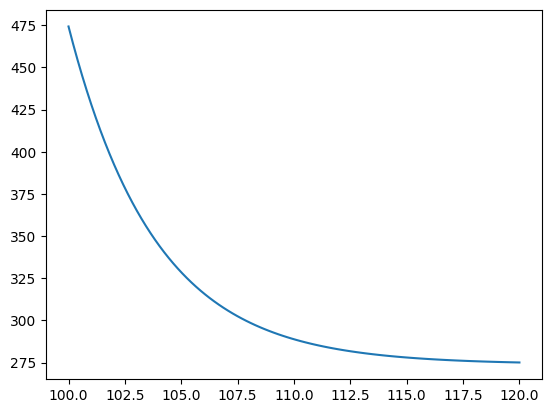

In [404]:
planned_production = [int(x) for x in planned_production]
a = min(planned_production)
b = max(planned_production)
def elasticity_func(x):
    return b * np.exp(-0.26 * x) * 1e11 + a
pricing_level = np.linspace(100, 120, 100)
plt.plot(pricing_level, elasticity_func(pricing_level))

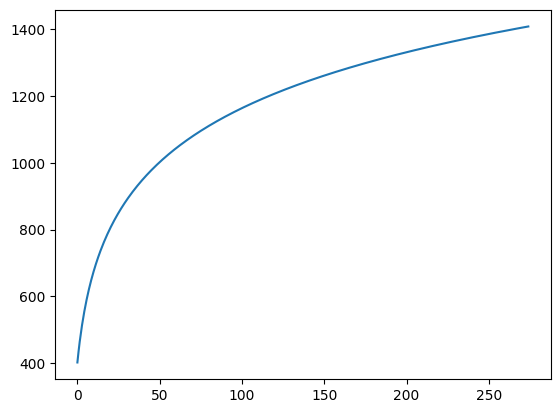

In [405]:
def inventory(x):
    a = 0.2
    return 250 * np.log(x + 5)
inv_level = np.linspace(0, a, b)
plt.plot(inv_level, inventory(inv_level))

In [406]:
storage_limit = a/2
storage_limit

137.0

In [407]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

planned_production = [367.147, 350.773, 320.989, 
                     315.163, 295.472, 274.848, 
                     303.273, 299.824, 327.777, 
                     325.285, 378.159, 392.429]

planned_production = [int(x) for x in planned_production]

a = min(planned_production)
b = max(planned_production)

def profit(pricing_level, storage_limit=None):
    revenue = pricing_level * elasticity_func(pricing_level)
    if storage_limit:
        inv_level = minimize(lambda x: -inventory(x), x0=[storage_limit], bounds=[(0, storage_limit)])
    else:
        inv_level = minimize(lambda x: -inventory(x), x0=[a], bounds=[(0, a)])
    inventory_cost = inventory(inv_level.x)
    gross_profit = revenue - inventory_cost
    return -gross_profit

result_with_storage_limit = minimize(profit, x0=[100], args=(storage_limit,), bounds=[(100, 120)])
result_without_storage_limit = minimize(profit, x0=[100], bounds=[(100, 120)])


print("Optimal Pricing Level with Storage Limitation:", result_with_storage_limit.x[0])
print("Max Gross Profit with Storage Limitation:", -result_with_storage_limit.fun)

print("\nOptimal Pricing Level without Storage Limitation:", result_without_storage_limit.x[0])
print("Max Gross Profit without Storage Limitation:", -result_without_storage_limit.fun)

Optimal Pricing Level with Storage Limitation: 100.0
Max Gross Profit with Storage Limitation: 46188.672225607916

Optimal Pricing Level without Storage Limitation: 100.0
Max Gross Profit without Storage Limitation: 46019.826044552894


In [408]:
pricing_levels = np.linspace(100, 120, 100)
profits_with_storage_limit = [profit(p, storage_limit) for p in pricing_levels]
profits_without_storage_limit = [profit(p, storage_limit*2) for p in pricing_levels]
